# This notebook compares eukaryotic taxa seen in shotgun metagenomes with those in metabarcoding sequence data. It is designed to use the output of sourmash for shotgun metagenomes and DADA2, BLAST, and MEGAN LCA for metabarcoding data. Sourmash databases should be GTDB and MMETSP and BLAST database should be NCBI-nr.

## This is currently written to assess taxa at the genus level, but can easily be modified for other levels of taxonomic resolution. Additionally, GTDB and MMETSP only contain microbial taxa (prokaryotic and eukaryotic, respectively). For higher organisms, different databases will be needed. I will address those questions in a separate script.

In [1]:
import pandas as pd
import os as os
import glob as glob
import numpy as np
import functools as ft
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## 01. Compile lists of species and genera observed in shotgun metagenomes

### Function to combine and reformat genus- and species-level data

In [2]:
def compile_taxa_lists(file, sample):
    tax = pd.read_csv(file)
    names = ['query name','rank','fraction','lineage','query_md5','query_filename',
         'f_weighted_at_rank','bp_match_at_rank']
    tax.columns = names
    lineage = tax[['lineage']].copy()
    lineage[['Domain','Phylum','Class','Order','Family','Genus',
             'Species']] = lineage['lineage'].str.split(';', n=7, expand=True)
    euks = lineage.loc[lineage['Domain'] == 'Eukaryota']
    euk_genus = pd.DataFrame(euks['Genus'].unique())
    euk_genus.columns = ['Genus']
    euk_genus = euk_genus.dropna()
    euk_genus['Metagenome_sample'] = sample
    euk_species = pd.DataFrame(euks['Species'].unique())
    euk_species.columns = ['Species']
    euk_species = euk_species.dropna()
    euk_species['Metagenome_sample'] = sample
    return(euk_genus, euk_species)

### Apply function to all samples in a directory

In [6]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/eCruises 2018/Flyer2018/Metagenomes/sourmash/tax/summaries")

In [7]:
df_gen_mgns = []
df_spp_mgns = []

for file in glob.glob('*summarized.csv'):
    a, b = file.split('_R1') # '_S' for Lasker, '_R1' for Flyer data; change as needed for other data sets
    gen, sp = compile_taxa_lists(file, a)
    df_gen_mgns.append(gen)
    df_spp_mgns.append(sp)
    
df_gen_mgns = pd.concat(df_gen_mgns)
df_spp_mgns = pd.concat(df_spp_mgns)

### Assign identifier to dataframe and repeat the process for other data set(s)

In [5]:
df_gen_mgns_Lasker2018 = df_gen_mgns

In [8]:
df_gen_mgns_Flyer2018 = df_gen_mgns

### Combine two dataframes

In [9]:
df_gen_mgns = pd.concat([df_gen_mgns_Lasker2018, df_gen_mgns_Flyer2018], axis=0)
df_gen_mgns

,Genus,Metagenome_sample
1,Bathycoccus,D0079A
2,Micromonas,D0079A
3,Aureococcus,D0079A
4,Pelagomonas,D0079A
5,Emiliania,D0079A
...,...,...
7,Prasinoderma,zr2760_39
8,Pycnococcus,zr2760_39
9,Florenciella,zr2760_39
10,Ostreococcus,zr2760_39


## 02. Compile lists of species and genera observed in metabarcoding data

### Can use either 18S or COI data

In [15]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/eCruises 2018/Lasker2018/Metagenomes/sourmash/COI comparison")

### Import and filter ASV table

In [16]:
file = 'RREAS2018_COI_otu_filtered_tax_mgnmatches.csv'
asvs = pd.read_csv(file)
asvs = asvs[(asvs['Kingdom'] != 'no_hit') & 
            (asvs['Kingdom'] != 'unassigned')] # Remove ASVs wit 'no_hit' or 'unassigned' in Kingdom
asvs

,lineage,Kingdom,Phylum,Class,Order,Family,Genus,Species,Lasker18Sc122_3_D0052_VV,Lasker18Sc122_5_D0053_VV,...,Lasker18Sc134_3_D0158_VV,Lasker18Sc134_5_D0159_VV,Lasker18Sc134_17_D0163_VV,Lasker18Sc134_19_D0164_VV,Lasker18Sc135_17_D0173_VV,Lasker18Sc135_19_D0174_VV,Lasker18Sc158_3_D0270_VV,Lasker18Sc158_5_D0271_VV,Lasker18Sc158_17_D0275_VV,Lasker18Sc158_19_D0276_VV
1,Eukaryota;Haptista;Haptophyta;Isochrysidales;N...,Eukaryota,Haptista,Haptophyta,Isochrysidales,Noelaerhabdaceae,Emiliania,Emiliania huxleyi,1032,1461,...,217,252,329,147,236,146,217,146,290,301
2,Eukaryota;Arthropoda;Hexanauplia;Poecilostomat...,Eukaryota,Arthropoda,Hexanauplia,Poecilostomatoida,Oncaeidae,g_,s_,2347,3,...,3062,2,0,0,2,0,22,4709,1,1
5,Eukaryota;Picozoa;unknown;unknown;unknown;g_;s_,Eukaryota,Picozoa,unknown,unknown,unknown,g_,s_,0,54,...,2322,5073,3424,2685,5331,5735,576,1978,4019,3061
6,Eukaryota;unassigned;unassigned;unassigned;una...,Eukaryota,unassigned,unassigned,unassigned,unassigned,g_,s_,0,0,...,49,0,0,0,0,638,0,0,0,1170
7,Eukaryota;unassigned;unassigned;unassigned;una...,Eukaryota,unassigned,unassigned,unassigned,unassigned,g_,s_,0,0,...,0,0,1,0,0,260,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9350,Eukaryota;Arthropoda;unassigned;unassigned;una...,Eukaryota,Arthropoda,unassigned,unassigned,unassigned,g_,s_,0,0,...,0,0,0,0,0,0,0,0,0,0
9351,Eukaryota;unassigned;unassigned;unassigned;una...,Eukaryota,unassigned,unassigned,unassigned,unassigned,g_,s_,0,0,...,0,0,0,0,0,0,0,0,0,0
9352,Eukaryota;Bacillariophyta;Coscinodiscophyceae;...,Eukaryota,Bacillariophyta,Coscinodiscophyceae,Rhizosoleniales,Rhizosoleniaceae,Rhizosolenia,s_,0,0,...,0,0,0,0,0,0,0,0,0,0
9353,Eukaryota;Cnidaria;Hydrozoa;Leptothecata;Aglao...,Eukaryota,Cnidaria,Hydrozoa,Leptothecata,Aglaopheniidae,g_,s_,0,0,...,0,0,0,0,0,0,0,0,0,0


### Function to reformat taxa lists

In [18]:
def reformat_ASV_table(df, taxon_to_drop):
    samples = [col for col in df.columns if 'Lasker' in col] # Use identifier in all sample names
    cols_to_drop = ['lineage','Kingdom','Phylum','Class','Order','Family',taxon_to_drop]
    df = df.drop(cols_to_drop, axis=1)
    taxon = [x for x in df.columns if 'Lasker' not in x] # Use identifier in all sample names
    df_melt = pd.melt(df, id_vars=taxon, value_vars=samples)
    df_melt = df_melt.rename(columns = {'variable':'ASV_sample', 
                                                    'value':'Read count'})
    mask = ['g_', 's_', 'unknown', 'unassigned'] # identify ASVs where taxon is unknown or unassigned
    taxon = ''.join(taxon) # Convert list to string
    df_asvs = df_melt.loc[~df_melt[taxon].isin(mask), :]
    df_asvs = df_asvs[df_asvs['Read count'] != 0]
    df_asvs = df_asvs.drop(['Read count'], axis=1)
    df_asvs = df_asvs.drop_duplicates()
    return(df_asvs)

#### For genus-level list

In [19]:
df_gen_asvs = reformat_ASV_table(asvs, 'Species')
df_gen_asvs

,Genus,ASV_sample
0,Emiliania,Lasker18Sc122_3_D0052_VV
6,Acanthephyra,Lasker18Sc122_3_D0052_VV
7,Phaeocystis,Lasker18Sc122_3_D0052_VV
16,Sphaeronectes,Lasker18Sc122_3_D0052_VV
42,Aureococcus,Lasker18Sc122_3_D0052_VV
...,...,...
206535,Chloroparvula,Lasker18Sc158_19_D0276_VV
206574,Megaptera,Lasker18Sc158_19_D0276_VV
206726,Polyneura,Lasker18Sc158_19_D0276_VV
207736,Laminariocolax,Lasker18Sc158_19_D0276_VV


#### For species-level list

In [20]:
df_spp_asvs = reformat_ASV_table(asvs, 'Genus')
df_spp_asvs

,Species,ASV_sample
0,Emiliania huxleyi,Lasker18Sc122_3_D0052_VV
6,Acanthephyra curtirostris,Lasker18Sc122_3_D0052_VV
7,Phaeocystis globosa,Lasker18Sc122_3_D0052_VV
16,Sphaeronectes gracilis,Lasker18Sc122_3_D0052_VV
42,Aureococcus anophagefferens,Lasker18Sc122_3_D0052_VV
...,...,...
206423,Dendraster excentricus,Lasker18Sc158_19_D0276_VV
206535,Chloroparvula pacifica,Lasker18Sc158_19_D0276_VV
206574,Megaptera novaeangliae,Lasker18Sc158_19_D0276_VV
206726,Polyneura latissima,Lasker18Sc158_19_D0276_VV


### Assign identifier to dataframe and repeat the process for other data set(s)

In [21]:
df_gen_asvs_Lasker2018 = df_gen_asvs

In [14]:
df_gen_asvs_Flyer2018 = df_gen_asvs

### Combine two dataframes

In [23]:
df_gen_asvs = pd.concat([df_gen_asvs_Lasker2018, df_gen_asvs_Flyer2018], axis=0)
df_gen_asvs

,Genus,ASV_sample
0,Emiliania,Lasker18Sc122_3_D0052_VV
6,Acanthephyra,Lasker18Sc122_3_D0052_VV
7,Phaeocystis,Lasker18Sc122_3_D0052_VV
16,Sphaeronectes,Lasker18Sc122_3_D0052_VV
42,Aureococcus,Lasker18Sc122_3_D0052_VV
...,...,...
562051,Rhizosolenia,CN18Sc27_8_eDNA
562118,Skeletonema,CN18Sc27_8_eDNA
562973,Pseudo-nitzschia,CN18Sc27_8_eDNA
564100,Scrippsia,CN18Sc27_8_eDNA


## 03. Extract taxa common to both data sets and taxa unique to one data set

### To get genera present in both sheets

In [25]:
genera_same = pd.merge(df_gen_mgns, df_gen_asvs, how = 'inner', on = ['Genus'])
#genera_same

### To get genera only in one sheet or another

In [26]:
common = df_gen_mgns.merge(df_gen_asvs, on=['Genus'])

#### Present only in metagenomes

In [27]:
df_gen_mgns[(~df_gen_mgns.Genus.isin(common.Genus))]

,Genus,Metagenome_sample
4,Pelagomonas,D0079A
6,Bolidomonas,D0079A
7,Chrysochromulina,D0079A
8,Ochromonas,D0079A
9,Isochrysis,D0079A
...,...,...
1,Minutocellus,zr2760_39
3,Pelagomonas,zr2760_39
7,Prasinoderma,zr2760_39
8,Pycnococcus,zr2760_39


#### Present only in amplicons

In [28]:
df_gen_asvs[(~df_gen_asvs.Genus.isin(common.Genus))]

,Genus,ASV_sample
6,Acanthephyra,Lasker18Sc122_3_D0052_VV
16,Sphaeronectes,Lasker18Sc122_3_D0052_VV
94,Clausocalanus,Lasker18Sc122_3_D0052_VV
133,Thysanoessa,Lasker18Sc122_3_D0052_VV
155,Praya,Lasker18Sc122_3_D0052_VV
...,...,...
560899,Nanomia,CN18Sc27_8_eDNA
561674,Leuckartiara,CN18Sc27_8_eDNA
561750,Stephanopyxis,CN18Sc27_8_eDNA
564100,Scrippsia,CN18Sc27_8_eDNA


## 04. Extract taxa seen only in one of the two paired samples

In [29]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/eCruises_TIMESERIES/Euks-mgns-asvs")

#### Load file showing paired sample names and turn pairs into a dictionary

In [30]:
file = 'eCruises2018_mgn_asv_paired_samples.csv'
pairs = pd.read_csv(file)

#### Add paired sample names to ASV and metagenome genus lists

In [31]:
df_gen_asvs_paired = df_gen_asvs.merge(pairs, how='left', on='ASV_sample')
df_gen_mgns_paired = df_gen_mgns.merge(pairs, how='left', on='Metagenome_sample')
df_gen_asvs_paired

,Genus,ASV_sample,Metagenome_sample
0,Emiliania,Lasker18Sc122_3_D0052_VV,NaN
1,Acanthephyra,Lasker18Sc122_3_D0052_VV,NaN
2,Phaeocystis,Lasker18Sc122_3_D0052_VV,NaN
3,Sphaeronectes,Lasker18Sc122_3_D0052_VV,NaN
4,Aureococcus,Lasker18Sc122_3_D0052_VV,NaN
...,...,...,...
2293,Rhizosolenia,CN18Sc27_8_eDNA,zr2760_70
2294,Skeletonema,CN18Sc27_8_eDNA,zr2760_70
2295,Pseudo-nitzschia,CN18Sc27_8_eDNA,zr2760_70
2296,Scrippsia,CN18Sc27_8_eDNA,zr2760_70


#### Extract genera seen in all ASV samples, with or without matching pair

In [32]:
df_gen_asvs_total = df_gen_asvs_paired.merge(df_gen_mgns_paired, how='left', 
                                            on=['Genus', 'ASV_sample']).drop(columns=['Metagenome_sample_x'])
df_gen_asvs_total

,Genus,ASV_sample,Metagenome_sample_y
0,Emiliania,Lasker18Sc122_3_D0052_VV,NaN
1,Acanthephyra,Lasker18Sc122_3_D0052_VV,NaN
2,Phaeocystis,Lasker18Sc122_3_D0052_VV,NaN
3,Sphaeronectes,Lasker18Sc122_3_D0052_VV,NaN
4,Aureococcus,Lasker18Sc122_3_D0052_VV,NaN
...,...,...,...
2293,Rhizosolenia,CN18Sc27_8_eDNA,NaN
2294,Skeletonema,CN18Sc27_8_eDNA,zr2760_70
2295,Pseudo-nitzschia,CN18Sc27_8_eDNA,NaN
2296,Scrippsia,CN18Sc27_8_eDNA,NaN


#### Extract genera seen in all metagenome samples, with or without matching pair

In [33]:
df_gen_mgns_total = df_gen_mgns_paired.merge(df_gen_asvs_paired, how='left', 
                                            on=['Genus', 'Metagenome_sample']).drop(columns=['ASV_sample_x'])
df_gen_mgns_total

,Genus,Metagenome_sample,ASV_sample_y
0,Bathycoccus,D0079A,NaN
1,Micromonas,D0079A,NaN
2,Aureococcus,D0079A,NaN
3,Pelagomonas,D0079A,NaN
4,Emiliania,D0079A,NaN
...,...,...,...
1799,Prasinoderma,zr2760_39,NaN
1800,Pycnococcus,zr2760_39,NaN
1801,Florenciella,zr2760_39,NaN
1802,Ostreococcus,zr2760_39,NaN


#### Extract genera seen ONLY in matched sample pairs

In [34]:
df_gen_pairmatches = df_gen_mgns_paired.merge(df_gen_asvs_paired, how='inner', 
                                            on=['Genus', 'ASV_sample', 'Metagenome_sample'])
df_gen_pairmatches

,Genus,Metagenome_sample,ASV_sample
0,Micromonas,zr2760_78,CN18SESPkoa_SC44
1,Skeletonema,zr2760_78,CN18SESPkoa_SC44
2,Phaeocystis,zr2760_78,CN18SESPkoa_SC44
3,Thalassiosira,zr2760_78,CN18SESPkoa_SC44
4,Emiliania,zr2760_78,CN18SESPkoa_SC44
...,...,...,...
260,Emiliania,zr2760_28,CN18Fc30_4_eDNA
261,Bathycoccus,zr2760_39,CN18FESPkoa_SC57
262,Micromonas,zr2760_39,CN18FESPkoa_SC57
263,Emiliania,zr2760_39,CN18FESPkoa_SC57


#### Extract taxa only seen in ASV or metagenome sample of each pair

In [35]:
# Subtract the pair-matched taxa df from the df of all ASV taxa
df_gen_asvs_total = df_gen_asvs_total.rename(columns={'Metagenome_sample_y':'Metagenome_sample'})
df_gen_asvs_only = pd.concat([df_gen_asvs_total, 
                                    df_gen_pairmatches, 
                                    df_gen_pairmatches]).drop_duplicates(keep=
                                                           False)
df_gen_asvs_only

,Genus,ASV_sample,Metagenome_sample
0,Emiliania,Lasker18Sc122_3_D0052_VV,NaN
1,Acanthephyra,Lasker18Sc122_3_D0052_VV,NaN
2,Phaeocystis,Lasker18Sc122_3_D0052_VV,NaN
3,Sphaeronectes,Lasker18Sc122_3_D0052_VV,NaN
4,Aureococcus,Lasker18Sc122_3_D0052_VV,NaN
...,...,...,...
2292,Stephanopyxis,CN18Sc27_8_eDNA,NaN
2293,Rhizosolenia,CN18Sc27_8_eDNA,NaN
2295,Pseudo-nitzschia,CN18Sc27_8_eDNA,NaN
2296,Scrippsia,CN18Sc27_8_eDNA,NaN


In [36]:
# Subtract the pair-matched taxa df from the df of all metagenome taxa
df_gen_mgns_total = df_gen_mgns_total.rename(columns={'ASV_sample_y':'ASV_sample'})
df_gen_mgns_only = pd.concat([df_gen_mgns_total, 
                                    df_gen_pairmatches, 
                                    df_gen_pairmatches]).drop_duplicates(keep=
                                                           False)
df_gen_mgns_only

,Genus,Metagenome_sample,ASV_sample
0,Bathycoccus,D0079A,NaN
1,Micromonas,D0079A,NaN
2,Aureococcus,D0079A,NaN
3,Pelagomonas,D0079A,NaN
4,Emiliania,D0079A,NaN
...,...,...,...
1799,Prasinoderma,zr2760_39,NaN
1800,Pycnococcus,zr2760_39,NaN
1801,Florenciella,zr2760_39,NaN
1802,Ostreococcus,zr2760_39,NaN


#### Group and count taxa seen in all three data sets: for each sample pair, (a) only in ASV sample, (b) only in metagenome sample, (c) in both 

In [37]:
dfs = [df_gen_pairmatches, df_gen_mgns_only, df_gen_asvs_only]
names = ['df_gen_pairmatches', 'df_gen_mgns_only', 'df_gen_asvs_only']

In [38]:
def group_count_taxa(df, name):
    dfs_counts[name + '_counts'] = df.groupby(['Genus']).count()
    return(dfs_counts)

In [39]:
dfs_counts = {}
for i in range(0,3):
    dfs_counts = group_count_taxa(dfs[i], names[i])

In [40]:
df_gen_pairmatches_counts = dfs_counts['df_gen_pairmatches_counts'].rename(columns=
                                                                           {'ASV_sample':'Pair matched'}).drop(columns=
                                                                                                               'Metagenome_sample')

In [41]:
df_gen_mgns_only_counts = dfs_counts['df_gen_mgns_only_counts'].rename(columns=
                                                                       {'Metagenome_sample':'Metagenome only'}).drop(columns=
                                                                                                                     'ASV_sample')

In [42]:
df_gen_asvs_only_counts = dfs_counts['df_gen_asvs_only_counts'].rename(columns=
                                                                       {'ASV_sample':'ASV only'}).drop(columns=
                                                                                                       'Metagenome_sample')

#### Combine all three data sets: for each sample pair, which taxa were seen (a) only in the ASV sample, (b) only in the metagenome sample, or (c) in both

In [43]:
dfs = [df_gen_pairmatches_counts, df_gen_mgns_only_counts, df_gen_asvs_only_counts]

In [44]:
df_three = ft.reduce(lambda left, right: pd.merge(left, 
                                                  right, 
                                                  left_index=True, 
                                                  right_index=True,
                                                 how='outer'),
                    dfs).reset_index().fillna(0)
df_three

,Genus,Pair matched,Metagenome only,ASV only
0,Acanthamoeba,0.0,0.0,2.0
1,Acanthephyra,0.0,0.0,21.0
2,Acanthoeca-like,0.0,6.0,0.0
3,Acanthoptilum,0.0,0.0,2.0
4,Acartia,0.0,0.0,82.0
...,...,...,...,...
175,Unidentifiedeukaryote,0.0,57.0,0.0
176,Urodasys,0.0,0.0,70.0
177,Vannella,0.0,4.0,0.0
178,Woloszynskia,0.0,0.0,1.0


#### Format for plotting

In [45]:
df_final = pd.melt(df_three, id_vars=['Genus'], 
                   value_vars=['ASV only', 'Metagenome only', 'Pair matched']).fillna(0).rename(columns=
                                                                                                    {'variable':'Observation group', 
                                                                                                     'value':'Count'}).sort_values(by='Genus')
df_final

,Genus,Observation group,Count
0,Acanthamoeba,ASV only,2.0
180,Acanthamoeba,Metagenome only,0.0
360,Acanthamoeba,Pair matched,0.0
1,Acanthephyra,ASV only,21.0
181,Acanthephyra,Metagenome only,0.0
...,...,...,...
178,Woloszynskia,ASV only,1.0
358,Woloszynskia,Metagenome only,0.0
359,Xiphinema,Metagenome only,0.0
179,Xiphinema,ASV only,3.0


#### Stacked bar plot of all genera in all samples

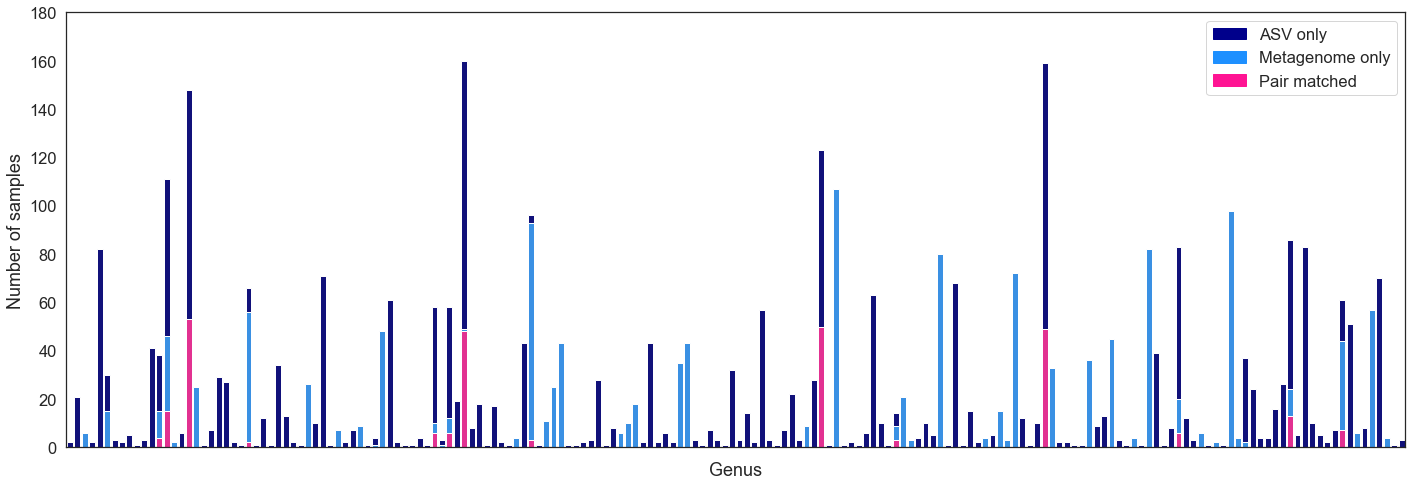

In [50]:
plt.figure(figsize=(24,8))
sns.set(font_scale = 1.5)
sns.set_style('white')
sns.set_palette(sns.color_palette('colorblind'))

# top bar -> sum all values(ASV only, pair matched, and metagenome only) to find y position of the bars
total = df_final.groupby('Genus')['Count'].sum().reset_index()

# bar chart 1 -> top bars (total counts)
bar1 = sns.barplot(x="Genus",  y="Count", data=total, color='darkblue', alpha=1)

# bottom bar 1 ->  take only metagenome-only values from the data
mgns = df_final[df_final['Observation group']=='Metagenome only']

# bar chart 2 -> bottom bars (group of 'Metagenome only')
bar2 = sns.barplot(x="Genus",  y="Count", data=mgns, color='dodgerblue', alpha=1) # estimator=sum, ci=None,  

# bottom bar 2 ->  take only pair matched samples
pairs = df_final[df_final['Observation group']=='Pair matched']

# bar chart 3 -> bottom bars (pair matched samples)
bar3 = sns.barplot(x="Genus",  y="Count", data=pairs, color='deeppink', alpha=1) # estimator=sum, ci=None,  

# add legend
top_bar = mpatches.Patch(color='darkblue', label='ASV only')
middle_bar = mpatches.Patch(color='dodgerblue', label='Metagenome only')
bottom_bar = mpatches.Patch(color='deeppink', label='Pair matched')

plt.legend(handles=[top_bar, middle_bar, bottom_bar])

plt.ylabel("Number of samples", size=18)
bar1.set_xticklabels([])
plt.xlabel("Genus", size=18)

plt.ylim(0, 180)
plt.savefig('eCruises2018_genera_metagenomes_COI_bars_ALL_stacked.svg', format='svg', dpi=1200, bbox_inches='tight')

### Split the entire df into smaller ones

#### First look at all taxa with any pair matching

In [51]:
df_subset_highpairmatches = df_final[(df_final['Observation group'] == 'Pair matched') &
                     (df_final['Count'] > 0)]
genus_a = df_subset_highpairmatches['Genus']
df_final_a = df_final[df_final['Genus'].isin(genus_a)]

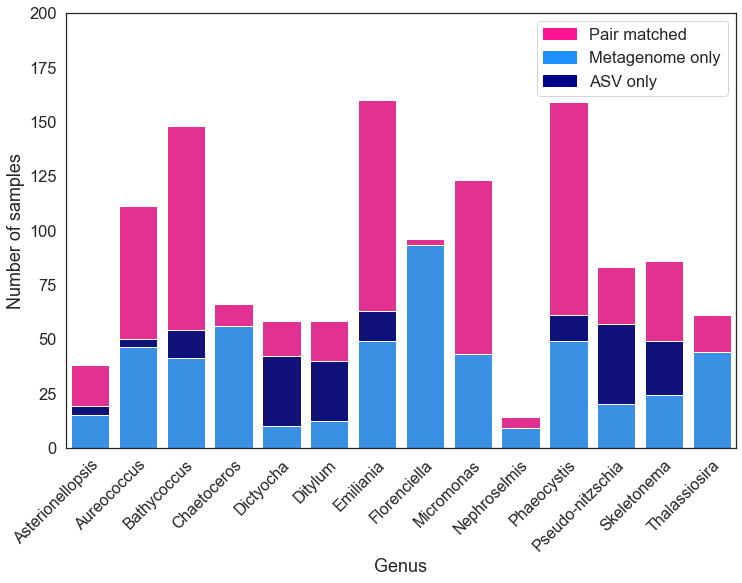

In [55]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 1.5)
sns.set_style('white')

# top bar -> sum all values(ASV only, pair matched, and metagenome only) to find y position of the bars
total = df_final_a.groupby('Genus')['Count'].sum().reset_index()

# bar chart 1 -> top bars (total counts)
bar1 = sns.barplot(x="Genus",  y="Count", data=total, color='deeppink', alpha=1)

# bottom bar 1 ->  take only metagenome-only values from the data
mgns = df_final_a[df_final_a['Observation group']=='ASV only']

# bar chart 2 -> bottom bars (group of 'Metagenome only')
bar2 = sns.barplot(x="Genus",  y="Count", data=mgns, color='darkblue', alpha=1) # estimator=sum, ci=None,  

# bottom bar 2 ->  take only pair matched samples
pairs = df_final_a[df_final_a['Observation group']=='Metagenome only']

# bar chart 3 -> bottom bars (pair matched samples)
bar3 = sns.barplot(x="Genus",  y="Count", data=pairs, color='dodgerblue', alpha=1) # estimator=sum, ci=None,  

# add legend
top_bar = mpatches.Patch(color='darkblue', label='ASV only')
middle_bar = mpatches.Patch(color='dodgerblue', label='Metagenome only')
bottom_bar = mpatches.Patch(color='deeppink', label='Pair matched')

plt.legend(handles=[bottom_bar, middle_bar, top_bar])

plt.ylabel("Number of samples", size=18)
bar1.set_xticklabels(bar1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor',
                    size=16)
plt.xlabel("Genus", size=18)
plt.ylim(0, 200)

plt.savefig('eCruises2018_genera_metagenomes_COI_bars_pairmatches_stacked.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

#### Genera with high levels of ASV-only observations

In [56]:
df_subset_highasvonly = df_final[(df_final['Observation group'] == 'ASV only') &
                     (df_final['Count'] > 20)]
genus_b = df_subset_highasvonly['Genus']
df_final_b = df_final[df_final['Genus'].isin(genus_b)]

#### Stacked bar plot

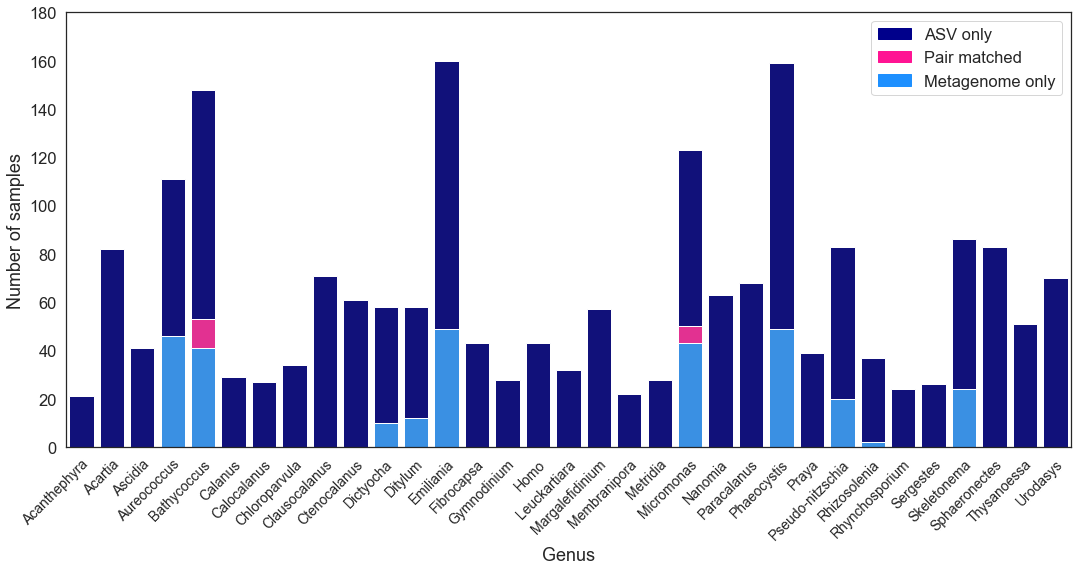

In [61]:
plt.figure(figsize=(18,8))
sns.set(font_scale = 1.5)
sns.set_style('white')
sns.set_palette(sns.color_palette('colorblind'))

# top bar -> sum all values(ASV only, pair matched, and metagenome only) to find y position of the bars
total = df_final_b.groupby('Genus')['Count'].sum().reset_index()

# bar chart 1 -> top bars (total counts)
bar1 = sns.barplot(x="Genus",  y="Count", data=total, color='darkblue', alpha=1)

# bottom bar 1 ->  take only metagenome-only values from the data
mgns = df_final_b[df_final_b['Observation group']=='Pair matched']

# bar chart 2 -> bottom bars (group of 'Metagenome only')
bar2 = sns.barplot(x="Genus",  y="Count", data=mgns, color='deeppink', alpha=1) # estimator=sum, ci=None,  

# bottom bar 2 ->  take only pair matched samples
pairs = df_final_b[df_final_b['Observation group']=='Metagenome only']

# bar chart 3 -> bottom bars (pair matched samples)
bar3 = sns.barplot(x="Genus",  y="Count", data=pairs, color='dodgerblue', alpha=1) # estimator=sum, ci=None,  

# add legend
top_bar = mpatches.Patch(color='darkblue', label='ASV only')
middle_bar = mpatches.Patch(color='deeppink', label='Pair matched')
bottom_bar = mpatches.Patch(color='dodgerblue', label='Metagenome only')

plt.legend(handles=[top_bar, middle_bar, bottom_bar])

plt.ylabel("Number of samples", size=18)
bar1.set_xticklabels(bar1.get_xticklabels(), rotation=45, size=14, ha='right', rotation_mode='anchor')
plt.ylim(0, 180)
plt.savefig('eCruises2018_genera_metagenomes_COI_bars_highasvsonly_stacked.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

#### Genera with any metagenome-only observations

In [62]:
df_subset_highmgnonly = df_final[(df_final['Observation group'] == 'Metagenome only') &
                     (df_final['Count'] > 0)]
genus_c = df_subset_highmgnonly['Genus']
df_final_c = df_final[df_final['Genus'].isin(genus_c)]

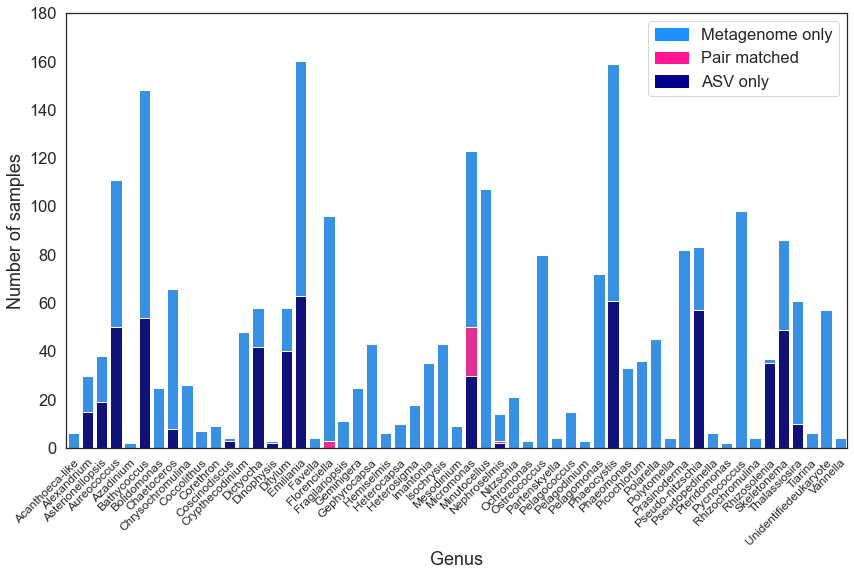

In [66]:
plt.figure(figsize=(14,8))
sns.set(font_scale = 1.5)
sns.set_style('white')

# top bar -> sum all values(ASV only, pair matched, and metagenome only) to find y position of the bars
total = df_final_c.groupby('Genus')['Count'].sum().reset_index()

# bar chart 1 -> top bars (total counts)
bar1 = sns.barplot(x="Genus",  y="Count", data=total, color='dodgerblue', alpha=1)

# bottom bar 1 ->  take only metagenome-only values from the data
mgns = df_final_c[df_final_c['Observation group']=='Pair matched']

# bar chart 2 -> bottom bars (group of 'Metagenome only')
bar2 = sns.barplot(x="Genus",  y="Count", data=mgns, color='deeppink', alpha=1) # estimator=sum, ci=None,  

# bottom bar 2 ->  take only pair matched samples
pairs = df_final_c[df_final_c['Observation group']=='ASV only']

# bar chart 3 -> bottom bars (pair matched samples)
bar3 = sns.barplot(x="Genus",  y="Count", data=pairs, color='darkblue', alpha=1) # estimator=sum, ci=None,  

# add legend
top_bar = mpatches.Patch(color='dodgerblue', label='Metagenome only')
middle_bar = mpatches.Patch(color='deeppink', label='Pair matched')
bottom_bar = mpatches.Patch(color='darkblue', label='ASV only')

plt.legend(handles=[top_bar, middle_bar, bottom_bar])

plt.ylabel("Number of samples", size=18)
bar1.set_xticklabels(bar1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor',
                    size=12)
plt.ylim(0, 180)
plt.savefig('eCruises2018_genera_metagenomes_COI_bars_mgnsonly_stacked.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

### Make histograms of number of genera in each observation group

#### Without y-axis break

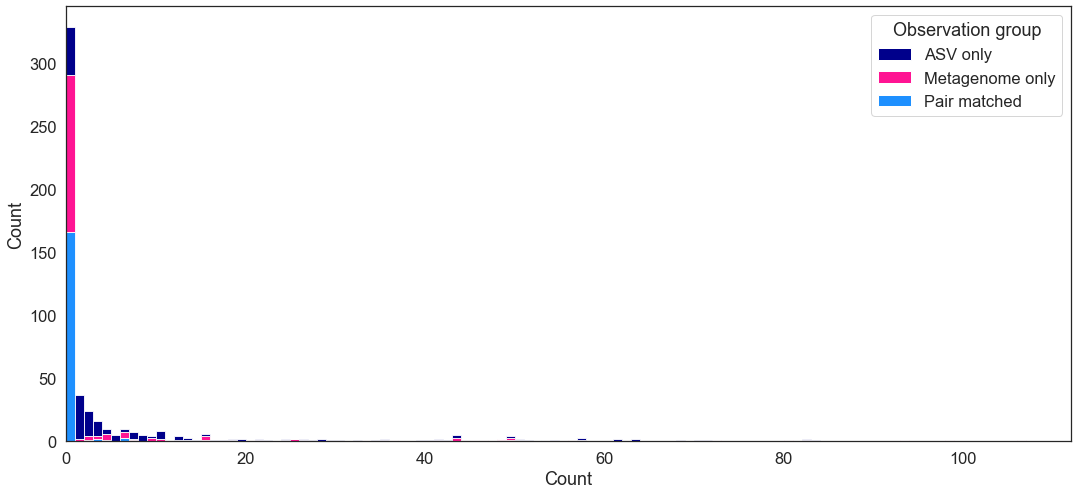

In [67]:
plt.figure(figsize=(18,8))
sns.set(font_scale = 1.5)
sns.set_style('white')
sns.set_palette(['darkblue','deeppink','dodgerblue'])

ax = sns.histplot(data=df_final, x='Count', hue='Observation group', 
                    alpha=1.0, binwidth=1, multiple='stack')

ax.set_xlim(0, 112)

plt.show()

#### With y-axis break

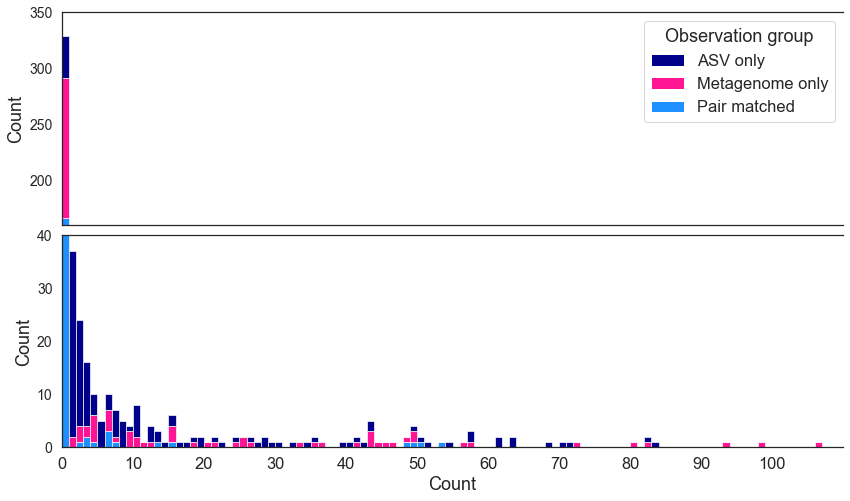

In [79]:
sns.set(font_scale = 1.5)
sns.set_style('white')
sns.set_palette(['darkblue','deeppink','dodgerblue'])

f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(14,8))
ax = sns.histplot(data=df_final, x='Count', hue='Observation group', 
                    alpha=1.0, binwidth=1, ax=ax1, multiple='stack')
ax = sns.histplot(data=df_final, x='Count', hue='Observation group', 
                    alpha=1.0, binwidth=1, ax=ax2, multiple='stack')
sns.despine(right=True, top=False) # , left = True
ax1.tick_params(axis='y', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=14)
ax1.tick_params(axis='x', which='both', labelsize=14)
ax2.legend([],[], frameon=False)

ax1.set_ylim(160, 350)
ax2.set_ylim(0, 40)
ax1.set_xlim(0, 110)
plt.xticks(np.arange(0, 110, 10))
plt.subplots_adjust(wspace=0, hspace=0.05)

In [80]:
f.savefig('eCruises2018_genera_metagenomes_COI_histogram.svg', format='svg', dpi=1200, bbox_inches='tight')